<a href="https://colab.research.google.com/github/ericburdett/cs601r-dl/blob/master/tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Handwritten Documents

### Imports
Dependencies needed to run the code, including mounting GoogleDrive and copying files.

In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import editdistance as ed
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader
assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

# Python
import gc
import os
import gzip
import tarfile
import time

# Data Structures
import pandas as pd
import numpy as np
import json
import csv

# Debug/Progress
from tqdm import tqdm
import pdb
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

# Image Manipulations / Plotting
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2

# Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp "drive/My Drive/datasets/iam.zip" "/content"
!cp "drive/My Drive/datasets/rimes.zip" "/content"
!unzip -q iam.zip -d iam
!unzip -q rimes.zip -d rimes
!wget -q https://raw.githubusercontent.com/ericburdett/cs601r-dl/master/char_set.json
!rm iam.zip
!rm rimes.zip

warning [iam.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [iam.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #95170).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


### Create IAM and RIMES Dataset Classes

In [0]:
class IamDataset(Dataset):
  def __init__(self, desired_size=(32, 128), total_imgs=None):
    self.desired_size = desired_size
    self.img_path = '/content/iam/images/'
    self.df = pd.read_csv('/content/iam/labels.csv', header=None, sep='\t', names=['word', 'seg', 'transcription'], quoting=csv.QUOTE_NONE)
    if total_imgs != None:
      self.df = self.df[:total_imgs]

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path + '.png')
    img = self.resize(img)
    # img = img.astype(np.float32)
    x = transforms.functional.to_tensor(img)

    return x

  def resize(self, img):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = self.desired_size[0] / self.desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = self.desired_size[0]
      new_width = int(self.desired_size[0] // img_ratio)
    else:
      new_height = int(self.desired_size[1] * img_ratio)
      new_width = self.desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = self.desired_size[0] - new_height
    border_right = self.desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=255)

    return img

  def __getitem__(self, index):
    path = 'iam/images/' + self.df['word'][index]
    img = self.tensor_image(path)

    return img, self.df['transcription'][index]

  def __len__(self):
    return len(self.df)


''' RIMES DATSET '''

class RimesDataset(Dataset):
  def __init__(self, desired_size=(32, 128), total_imgs=None):
    self.desired_size = desired_size
    self.img_path = '/content/rimes/images/'
    self.df = pd.read_csv('/content/rimes/labels.csv', header=None, sep='\t', names=['word', 'transcription'], quoting=csv.QUOTE_NONE)
    if total_imgs != None:
      self.df = self.df[:total_imgs]

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path)
    img = self.resize(img)
    # img = img.astype(np.float32)
    x = transforms.functional.to_tensor(img)

    return x

  def resize(self, img):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = self.desired_size[0] / self.desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = self.desired_size[0]
      new_width = int(self.desired_size[0] // img_ratio)
    else:
      new_height = int(self.desired_size[1] * img_ratio)
      new_width = self.desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = self.desired_size[0] - new_height
    border_right = self.desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=255)

    return img

  def __getitem__(self, index):
    path = 'rimes/images/' + self.df['word'][index]
    img = self.tensor_image(path)

    return img, self.df['transcription'][index]

  def __len__(self):
    return len(self.df)

Length:  25000
Transcription:  of


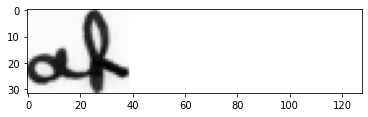

In [4]:
iam = IamDataset(total_imgs=25000)
index = 20

print('Length: ', len(iam))
print('Transcription: ', iam[index][1])
plt.imshow(iam[index][0].squeeze(), cmap='gray')

Length:  25000
Transcription:  elle


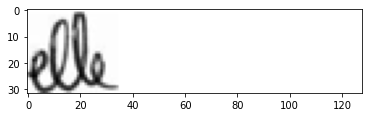

In [5]:
rimes = RimesDataset(total_imgs=25000)
index = 20

print('Length: ', len(rimes))
print('Transcription: ', rimes[index][1])
plt.imshow(rimes[index][0].squeeze(), cmap='gray')

### Character Encoding

In [0]:
class Encoder():
  def __init__(self, sequence_size=150):
    with open('char_set.json') as file:
      self.json = json.load(file)
    
    self.sequence_size = sequence_size

  def remove_duplicates(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      if i + 1 == len(idxs) or idxs[i] != idxs[i + 1]:
        new_idxs.append(idxs[i])
    
    return new_idxs
  
  def add_blanks(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      new_idxs.append(idxs[i])
      if i + 1 != len(idxs) and idxs[i] == idxs[i + 1]:
        new_idxs.append(0)
    
    return new_idxs
  
  def idx_to_char(self, idx):
    if idx == 0:
      return ''
    else:
      return self.json['idx_to_char'][str(int(idx))]
  
  def char_to_idx(self, char):
    return int(self.json['char_to_idx'][char])
  
  def str_to_idxs(self, string):
    idxs = []

    zeros = np.zeros(self.sequence_size)

    for char in string:
      idxs.append(self.char_to_idx(char))

    # Add blanks if CTC-Loss requires it...
    # idxs = self.add_blanks(idxs)

    idxs = np.concatenate((idxs, zeros))[:self.sequence_size]
    
    return idxs, len(string)

  def idxs_to_str(self, idxs):
    string = ''
    idxs = self.remove_duplicates(idxs)

    for idx in idxs:
      string += self.idx_to_char(idx)
    
    return string
  
  def str_to_idxs_batch(self, batch):
    idxs = []
    lengths = []

    for string in batch:
      idx, length = self.str_to_idxs(string)
      idxs.append(idx)
      if length > self.sequence_size:
        length = self.sequence_size
      lengths.append(length)
    
    return idxs, lengths
  
  def idxs_to_str_batch(self, batch):
    strings = []

    for idxs in batch:
      strings.append(self.idxs_to_str(idxs))
    
    return strings

### Helper Functions

In [0]:
def show_imgs(x, new_fig=True):
    grid = utils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure() # figsize=(50,100)
    plt.imshow(grid.numpy())

def parameter_count(model):
  return sum(p.numel() for p in model.parameters())

def err(prediction, target):
  dist = ed.eval(target, prediction)
  if len(target) == 0:
    return len(prediction)
  
  return float(dist) / float(len(target))

def cer(prediction, target):
  prediction = ' '.join(prediction.split())
  target = ' '.join(target.split())

  return err(prediction, target)

def wer(prediction, target):
  prediction = prediction.split()
  target = target.split()

  return err(prediction, target)

def cer_batch(predictions, targets):
  cers = []

  for prediction, target in zip(predictions, targets):
    cers.append(cer(prediction, target))
  
  return np.mean(cers)

def wer_batch(predictions, targets):
  wers = []

  for prediction, target in zip(predictions, targets):
    wers.append(wer(prediction, target))

  return np.mean(wers)

### Model

In [0]:
class Recognizer(nn.Module):
  def __init__(self, sequence_size=20):
    super(Recognizer, self).__init__()

    self.hidden_size = 256
    self.num_layers = 1
    self.sequence_size = sequence_size

    # Encoder
    self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
    self.tanh1 = nn.Tanh()
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1) # 4x2
    self.tanh2 = nn.Tanh()
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.tanh3 = nn.Tanh()
    self.conv4 = nn.Conv2d(32, 64, 3, 1, 1) # 4x2
    self.tanh4 = nn.Tanh()
    self.conv5 = nn.Conv2d(64, 128, 3, 1, 1)
    self.tanh5 = nn.Tanh()

    self.gate1 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate3 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())

    # Maxpool
    self.mp = nn.MaxPool2d((32, 1))

    # Decoder
    self.gru1 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, self.sequence_size)
    self.softmax = nn.LogSoftmax(dim=1)

  # Input -> (Batch, 1, 128, 256)
  def forward(self, x):
    # Encoder
    out = self.conv1(x)
    out = self.tanh1(out)
    out = self.conv2(out)
    out = self.tanh2(out)

    gate1 = self.gate1(out)
    out = out * gate1

    out = self.conv3(out)
    out = self.tanh3(out)

    gate2 = self.gate2(out)
    out = out * gate2

    out = self.conv4(out)
    out = self.tanh4(out)

    gate3 = self.gate3(out)
    out = out * gate3

    out = self.conv5(out)
    out = self.tanh5(out)

    # Max Pooling across vertical dimension
    out = self.mp(out)

    # Decoder
    out = out.view(-1, 128, 128)

    out, _ = self.gru1(out)
    out = self.fc1(out)
    out, _ = self.gru2(out)
    out = self.fc2(out)
    out = self.softmax(out)

    # Change shape so that we can pass directly to CTC-Loss
    out = out.permute(2, 0, 1)

    return out

### IAM/Rimes Training

In [0]:
def train(train_dataset, val_dataset, test_dataset):
  try:
    EPOCHS = 100
    BATCH_SIZE = 250
    ITERATION_SAMPLE = 3000
    SEQUENCE_SIZE = 20

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    encoder = Encoder(sequence_size=SEQUENCE_SIZE)
    recognizer = Recognizer(sequence_size=SEQUENCE_SIZE).cuda()
    
    optimizer = optim.Adam(recognizer.parameters(), lr=1e-3)

    objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)

    train_losses_epochs = []
    val_losses_epochs = []
    test_losses_epochs = []

    train_cer_epochs = []
    val_cer_epochs = []
    test_cer_epochs = []

    train_wer_epochs = []
    val_wer_epochs = []
    test_wer_epochs = []

    for epoch in range(EPOCHS):


      train_losses = []
      val_losses = []
      test_losses = []

      train_cers = []
      val_cers = []
      test_cers = []

      train_wers = []
      val_wers = []
      test_wers = []

      # Training Loop
      recognizer = recognizer.train()
      train_loop = tqdm(total=len(train_loader), position=0, leave=True)
      for batch_num, (imgs, words) in enumerate(train_loader):
        batch_size = imgs.shape[0]

        idxs, word_lengths = encoder.str_to_idxs_batch(words)

        imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

        input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
        target_lengths = torch.tensor(word_lengths).cuda()

        preds = recognizer(imgs)

        loss = objective(preds, labels, input_lengths, target_lengths)
        loss = torch.mean(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
        preds_cer = cer_batch(preds_strings, words)
        preds_wer = wer_batch(preds_strings, words)

        train_losses.append(loss.item())
        train_cers.append(preds_cer)
        train_wers.append(preds_wer)

        train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgLoss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
            epoch, loss.item(), preds_cer, preds_wer, np.mean(train_losses), np.mean(train_cers), np.mean(train_wers)))
        train_loop.update(1)
      
      train_loop.close()

      # Validation Loop
      recognizer = recognizer.eval()
      val_loop = tqdm(total=len(val_loader), position=0, leave=True)
      for batch_num, (imgs, words) in enumerate(val_loader):
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)

          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

          optimizer.zero_grad()

          input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
          target_lengths = torch.tensor(word_lengths).cuda()

          preds = recognizer(imgs)

          loss = objective(preds, labels, input_lengths, target_lengths)
          loss = torch.mean(loss)

          preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
          preds_cer = cer_batch(preds_strings, words)
          preds_wer = wer_batch(preds_strings, words)

          val_losses.append(loss.item())
          val_cers.append(preds_cer)
          val_wers.append(preds_wer)

          val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgLoss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
              epoch, loss.item(), preds_cer, preds_wer, np.mean(val_losses), np.mean(val_cers), np.mean(val_wers)))
          val_loop.update(1)

      val_loop.close()

      # Test Loop
      recognizer = recognizer.eval()
      test_loop = tqdm(total=len(test_loader), position=0, leave=True)
      for batch_num, (imgs, words) in enumerate(test_loader):
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)

          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

          optimizer.zero_grad()

          input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
          target_lengths = torch.tensor(word_lengths).cuda()

          preds = recognizer(imgs)

          loss = objective(preds, labels, input_lengths, target_lengths)
          loss = torch.mean(loss)

          preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
          preds_cer = cer_batch(preds_strings, words)
          preds_wer = wer_batch(preds_strings, words)

          test_losses.append(loss.item())
          test_cers.append(preds_cer)
          test_wers.append(preds_wer)

          test_loop.set_description('Test  - Epoch: {}, Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgLoss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
              epoch, loss.item(), preds_cer, preds_wer, np.mean(test_losses), np.mean(test_cers), np.mean(test_wers)))
          test_loop.update(1)

      test_loop.close()

      train_losses_epochs.append(np.mean(train_losses))
      val_losses_epochs.append(np.mean(val_losses))
      test_losses_epochs.append(np.mean(test_losses))

      train_cer_epochs.append(np.mean(train_cers))
      val_cer_epochs.append(np.mean(val_cers))
      test_cer_epochs.append(np.mean(test_cers))

      train_wer_epochs.append(np.mean(train_wers))
      val_wer_epochs.append(np.mean(val_wers))
      test_wer_epochs.append(np.mean(test_wers))
  except:
    __ITB__()
    gc.collect()
  finally:
    return recognizer, (train_losses_epochs, val_losses_epochs, test_losses_epochs), (train_cer_epochs, val_cer_epochs, test_cer_epochs), (train_wer_epochs, val_wer_epochs, test_wer_epochs) 

### Train on the IAM Dataset, Test on the Rimes Dataset

In [44]:
iam_dataset = IamDataset(desired_size=(32, 128), total_imgs=30000)

iam_train_size = int(.8 * len(iam_dataset))
iam_val_size = len(iam_dataset) - iam_train_size

iam_train_dataset, iam_val_dataset = torch.utils.data.random_split(iam_dataset, [iam_train_size, iam_val_size])

rimes_dataset = RimesDataset(desired_size=(32, 128), total_imgs=30000)
iam_to_rimes_recognizer, iam_to_rimes_losses, iam_to_rimes_cers, iam_to_rimes_wers = train(iam_train_dataset, iam_val_dataset, rimes_dataset)

Train - Epoch: 0, Loss: 17.4475, CER: 1.0000, WER: 1.0000, AvgLoss: 26.9922, AvgCER: 1.0402, AvgWER: 1.0104: 100%|██████████| 96/96 [00:30<00:00,  3.10it/s]
Val   - Epoch: 0, Loss: 16.8578, CER: 1.0000, WER: 1.0000, AvgLoss: 17.4199, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 24/24 [00:05<00:00,  4.56it/s]
Test  - Epoch: 0, Loss: 20.5452, CER: 1.0000, WER: 1.0000, AvgLoss: 20.2920, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 120/120 [00:23<00:00,  5.02it/s]
Train - Epoch: 1, Loss: 16.8822, CER: 1.0000, WER: 1.0000, AvgLoss: 16.8209, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 96/96 [00:30<00:00,  3.13it/s]
Val   - Epoch: 1, Loss: 16.9420, CER: 1.0000, WER: 1.0000, AvgLoss: 16.6630, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]
Test  - Epoch: 1, Loss: 20.4299, CER: 1.0000, WER: 1.0000, AvgLoss: 19.5130, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 120/120 [00:23<00:00,  5.06it/s]
Train - Epoch: 2, Loss: 17.1211, CER: 1.0000, WER: 1.0

### Results

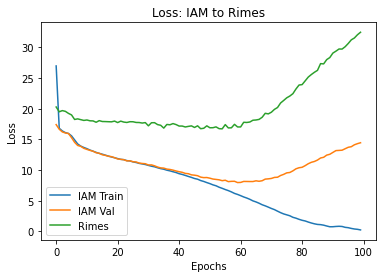

Train: [26.992212732632954, 16.82087700565656, 16.38394159078598, 16.112451473871868, 15.971416562795639, 15.582810908555984, 14.925958583752314, 14.26237565279007, 13.911991228659948, 13.689028759797415, 13.496922234694162, 13.267347753047943, 13.08597598473231, 12.891137013832727, 12.723054299751917, 12.593100845813751, 12.435029019912085, 12.284128030141195, 12.13704518477122, 12.010211169719696, 11.87728359301885, 11.751718997955322, 11.702802528937658, 11.545947869618734, 11.4891208310922, 11.335384756326675, 11.237780461708704, 11.092929343382517, 11.003456979990005, 10.908263276020685, 10.764028042554855, 10.631967653830847, 10.534312884012857, 10.376278032859167, 10.236186236143112, 10.142451951901117, 9.983394662539164, 9.874166915814081, 9.732331052422523, 9.599636554718018, 9.411615088582039, 9.289303551117579, 9.130164181192717, 8.965074554085732, 8.807909826437632, 8.628889699776968, 8.514992664257685, 8.291590929031372, 8.146245375275612, 7.960911591847737, 7.791693285107

In [45]:
plt.title('Loss: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(iam_to_rimes_losses[0], label='IAM Train')
plt.plot(iam_to_rimes_losses[1], label='IAM Val')
plt.plot(iam_to_rimes_losses[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', iam_to_rimes_losses[0])
print('Val:', iam_to_rimes_losses[1])
print('Test:', iam_to_rimes_losses[2])

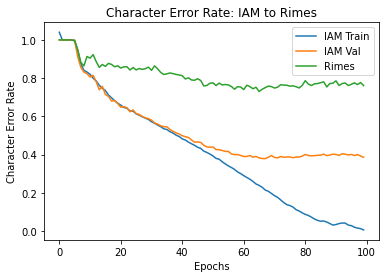

Train: [1.0401590473184223, 1.0, 1.0, 1.0, 0.999806216931217, 0.998764673463111, 0.945977441794997, 0.8747019000208097, 0.8406623856043409, 0.8319799546264136, 0.8203795013224435, 0.7999150135897816, 0.7848920738193911, 0.7625678453449787, 0.7464749001000791, 0.7351007743288703, 0.7117775131163627, 0.6972019252807806, 0.6819153380637465, 0.669244309112227, 0.6589343760067976, 0.6467182349957118, 0.6422326429427484, 0.6286961503648713, 0.6273260451807037, 0.613202109873772, 0.6065204388061199, 0.5977343815610988, 0.5905715764604261, 0.5837549107425656, 0.5718427684075613, 0.5636860963545899, 0.554513898531057, 0.5459472387075714, 0.5350457511308565, 0.5310785916699471, 0.5198420179019395, 0.5127188727260369, 0.5015153292914516, 0.4946358044394761, 0.4819727238322536, 0.47611797093765945, 0.46546720217436643, 0.4568180972258807, 0.44838415167706963, 0.4383253081862167, 0.43234157931887224, 0.4180610872372095, 0.41132491510163244, 0.40272310403985134, 0.39269925549936674, 0.38006496143694

In [46]:
plt.title('Character Error Rate: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Character Error Rate')
plt.plot(iam_to_rimes_cers[0], label='IAM Train')
plt.plot(iam_to_rimes_cers[1], label='IAM Val')
plt.plot(iam_to_rimes_cers[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', iam_to_rimes_cers[0])
print('Val:', iam_to_rimes_cers[1])
print('Test:', iam_to_rimes_cers[2])

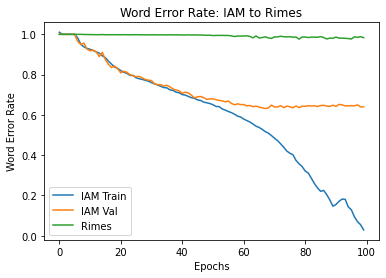

Train: [1.0104166666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9819583333333334, 0.9502083333333333, 0.9379583333333334, 0.9303750000000001, 0.9257916666666667, 0.9196250000000002, 0.9131666666666667, 0.9069583333333334, 0.8930833333333336, 0.884125, 0.8663333333333334, 0.8520416666666667, 0.8376250000000001, 0.8304166666666667, 0.8199583333333335, 0.8120833333333334, 0.8062916666666667, 0.7960000000000002, 0.7962083333333334, 0.7840416666666666, 0.7795000000000001, 0.7760833333333332, 0.7716249999999999, 0.7672916666666666, 0.7601666666666667, 0.7539583333333333, 0.7485833333333334, 0.7419583333333333, 0.7357083333333333, 0.7341666666666665, 0.7241666666666667, 0.7213333333333333, 0.712875, 0.7096666666666666, 0.7009166666666666, 0.6982083333333332, 0.6915, 0.6852916666666666, 0.6818750000000001, 0.6745416666666667, 0.6715833333333333, 0.6633333333333332, 0.6600833333333332, 0.656375, 0.6502083333333333, 0.6420416666666666, 0.6410833333333333, 0.6294583333333333, 0.6235416666666667, 0.61675, 

In [47]:
plt.title('Word Error Rate: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Word Error Rate')
plt.plot(iam_to_rimes_wers[0], label='IAM Train')
plt.plot(iam_to_rimes_wers[1], label='IAM Val')
plt.plot(iam_to_rimes_wers[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', iam_to_rimes_wers[0])
print('Val:', iam_to_rimes_wers[1])
print('Test:', iam_to_rimes_wers[2])